Assess the privacy risks in MOSTLY.AI synthetic data using our proposed privacy metrics.

In [20]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

Assess privacy risks in synthetic data based on the training set only.

In [6]:
train_data = pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/train_dataset.csv")

In [7]:
mostly_sXs = []

In [8]:
for i in range(20):
    sX = pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/mostly_holdout_synthetic_dataset_" + str(i) + ".csv")
    mostly_sXs.append(sX)

***

In [9]:
num_deltas = 20

In [10]:
deltas = np.geomspace(0.00001, 1.1, num=num_deltas)

In [11]:
def neighbor_finder(original_data, synthetic_data, deltas):
    
    full_matches = []
    
    # tree for original locations
    orig_tree = cKDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = cKDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the number of matches for each original row and the indices of those matches
        matches = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age', 'state']] == row[['sex', 'age', 'state']]).all(1)
        
            # store number of matches and their indices
            matches.append(np.sum(categorical_matches))
            
        full_matches.append(pd.Series(matches))
        
    print("Dataset completed.")
        
    return full_matches

In [12]:
neighborhood_stats = [neighbor_finder(train_data, Y, deltas) for Y in mostly_sXs]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [13]:
match_nums = [pd.concat(x, axis=1) for x in neighborhood_stats]

In [14]:
match_nums = np.dstack(match_nums)

In [15]:
pct_singled_out = np.sum(match_nums == 1.0, axis=0)/train_data.shape[0]

In [16]:
avg_pct_singled_out = np.mean(pct_singled_out, axis=1)

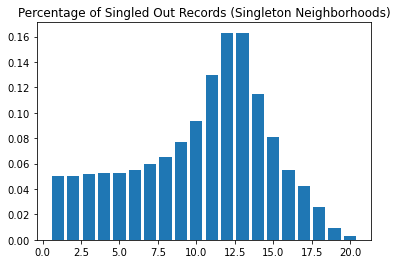

In [21]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_singled_out, align='center')
plt.title("Percentage of Singled Out Records (Singleton Neighborhoods)")
plt.show()

In [22]:
cutoff = 2

In [23]:
meet_cutoff = [[pd.concat([x == 0, x >= cutoff], axis=1).any(axis=1) for x in y] for y in neighborhood_stats]

In [24]:
meet_cutoff = [pd.concat(x, axis=1) for x in meet_cutoff]

In [25]:
meet_cutoff = np.dstack(meet_cutoff)

In [26]:
pct_meet_cutoff = np.mean(meet_cutoff, axis=0)

In [27]:
avg_pct_meet_cutoff = pct_meet_cutoff.mean(axis=1)

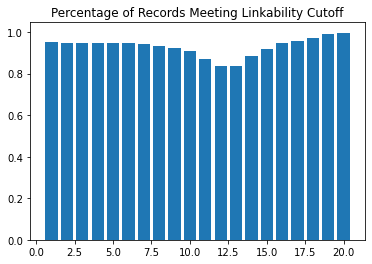

In [28]:
plt.bar(x=np.arange(1, num_deltas+1), height=avg_pct_meet_cutoff, align='center')
plt.title("Percentage of Records Meeting Linkability Cutoff")
plt.show()

In [29]:
np.min(avg_pct_meet_cutoff)

0.8369189511323004

In [30]:
prior_death_prob = 104/8897

In [31]:
def inference_evaluation(original_data, synthetic_data, prior_prob, deltas):
    
    full_inf_conds = []
    full_indices = []
    
    # tree for original locations
    orig_tree = cKDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = cKDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the inference condition for each original row and the indices of those rows that violate
        inf_conds = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age']] == row[['sex', 'age']]).all(1)
            
            matching_rows = synthetic_data.loc[location_neighbors[i],:].loc[categorical_matches.values,:]
            
            if matching_rows.shape[0] > 0:
                
                if row['state'] == 1.0:
                    prior = prior_prob
                else:
                    prior = 1 - prior_prob
            
                cond = np.mean(matching_rows['state'] == row['state'])/prior
                
            else:
                
                cond = 1
        
            # store number of matches and their indices
            inf_conds.append(cond)
        
        inf_conds = pd.Series(inf_conds)
        
        full_inf_conds.append(inf_conds)
        
    return full_inf_conds

In [35]:
inference_conditions = [inference_evaluation(train_data, Y, prior_death_prob, deltas) for Y in mostly_sXs]

In [36]:
inf_conds = [pd.concat(x, axis=1) for x in inference_conditions]

In [37]:
c_vec = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.20, 0.30, 0.40, 0.50]

In [38]:
proportion_meeting_inference = [[x <= (1 + c) for x in inf_conds] for c in c_vec]

In [39]:
proportion_meeting_inference = pd.concat([pd.concat([x.mean(axis=0) for x in y], axis=1).mean(axis=1) for y in proportion_meeting_inference], axis=1)

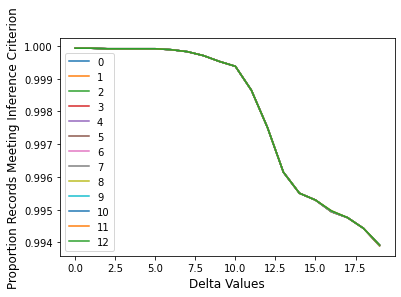

In [40]:
ax = proportion_meeting_inference.plot()
ax.set_ylabel('Proportion Records Meeting Inference Criterion', fontsize=12)
ax.set_xlabel('Delta Values', fontsize=12)
# legend shows different values of c - 0.01 to 0.09
plt.show()